In [1]:
%matplotlib inline
import os
import time
# os.environ['THEANO_FLAGS']='contexts=dev0->cuda0;dev1->cuda1'
os.environ['THEANO_FLAGS']='device=gpu0'
import theano
import lasagne
import numpy as np
import cPickle as pickle
import theano.tensor as T
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from lasagne.layers import InputLayer, DenseLayer, DropoutLayer
from helpers.DiscreteLayer import DiscreteLayer

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu0 is not available  (error: Unable to get the number of gpus available: unknown error)


# Breast Cancer dataset cl
* 30 Dimensions of Features
* 2 Classes
* 569 examples (212(M),357(B))

I'll be using ML.Perceptron, for classification

In [2]:
# Constants
NUM_EPOCHS = 1500
BATCH_SIZE = 256
LEARNING_RATE = 0.005
NUM_CLASSES = 2

# Disc. Layer Settings
DISC = False
QUANT = np.array([0.125, 0.125, 0.125, 0.125, 0.125], dtype='float32')
QUANT_UNIT = QUANT.shape[0]
VARIANCE_DEVIDER = 16.0

# Test Specs
TEST_NAME = 'breast-disc'

# Additional Settings
lasagne.random.set_rng(np.random.RandomState(12345))  # Set random state so we can investigate results
np.random.seed(1234)
#theano.config.exception_verbosity = 'high'

In [3]:
def load_dataset():
    dataset = load_breast_cancer()
    X = dataset['data']
    Y = dataset['target']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    return dict(X_train=X_train,
               y_train=y_train,
               X_test=X_test,
               y_test=y_test)
data = load_dataset()

In [4]:
def build_mlp(Xs, disc, classnum, QUANT_UNIT):
    rect = lasagne.nonlinearities.rectify
    softmax = lasagne.nonlinearities.softmax
    
    l_in = InputLayer(shape=Xs.shape)
    l_dense1 = DenseLayer(l_in, num_units=25, nonlinearity=rect)
    l_dense2 = DenseLayer(l_dense1, num_units=QUANT_UNIT, nonlinearity=rect, name='param_regressor')
    if disc:
        sharedBins = theano.shared(None, name='sharedBins')
        l_dis = DiscreteLayer(l_dense2, sharedBins=sharedBins, name='disclayer')
        print("Using Discret. Layer")
    else:
        l_dis = l_dense2
        print("No Disc. Layer")
    l_class = DenseLayer(l_dis, num_units=classnum, nonlinearity=softmax)
    
    if disc:
        return l_class, sharedBins
    else:
        return l_class

if DISC:
    model, sharedBins = build_mlp(data['X_train'], disc=DISC, classnum=NUM_CLASSES, QUANT_UNIT=QUANT_UNIT)
else:
    model = build_mlp(data['X_train'], disc=DISC, classnum=NUM_CLASSES, QUANT_UNIT=QUANT_UNIT)
model_params = lasagne.layers.get_all_params(model, trainable=True)

No Disc. Layer


In [5]:
"""
Input: dist, dist.shape = (-1, num_units)
Find quantization bins of a given dist history
Returns a list of (x, num_units), where x's length is a random variable
"""
def find_quantization_bins(dist, sharedBins):
    # Quantizer function
    def Q(x, y):
        return y * np.floor((x/y) + .5)
    
    shape = dist.shape
    init_Q = QUANT
    final_Q = []
    
    # Theta iterator
    for i in range(shape[1]):
        theta_i = dist[:, i]
        
        # Whats is the error threshold for this distribution
        Q_eps = np.var(theta_i) / VARIANCE_DEVIDER
        
        # Batch Iterator
        final_Q_i = []
        for j in range(shape[0]):
            theta = theta_i[j]
            
            # Quantized theta = Quantization bins
            q = init_Q[i]
            x_i = theta
            x_o = Q(x_i, q)
            
            # Optimize x_o

            while(np.abs(x_o - x_i) > Q_eps):
                q = q / 2
                x_o = Q(x_i, q)
            
            # End of optimisation
            final_Q_i.append(x_o)
        
        # Append to outer list
        uniques = np.unique(np.array(final_Q_i))
        final_Q.append(uniques.astype(theano.config.floatX))
        
    # Report
    print "New Bin Sizes: [" + ", ".join([str(final_Q[x].shape[0]) for x in range(shape[1])] ) + "]"
    sharedBins.set_value(final_Q)
    return final_Q

In [6]:
def build_functions():
    X = T.matrix(dtype=theano.config.floatX)
    y = T.ivector()

    ## Layer History
    if DISC:
        l_disc = next(l for l in lasagne.layers.get_all_layers(model) if l.name is 'disclayer')
        l_paramreg = next(l for l in lasagne.layers.get_all_layers(model) if l.name is 'param_regressor')
        l_disc_output, l_paramreg_output = lasagne.layers.get_output([l_disc, l_paramreg], X, deterministic=False)
    ## Layer History

    # training output
    output_train = lasagne.layers.get_output(model, X, deterministic=False)

    # evaluation output. Also includes output of transform for plotting
    output_eval = lasagne.layers.get_output(model, X, deterministic=True)

    sh_lr = theano.shared(lasagne.utils.floatX(LEARNING_RATE))
    cost = T.mean(T.nnet.categorical_crossentropy(output_train, y))
    updates = lasagne.updates.adam(cost, model_params, learning_rate=sh_lr)

    if DISC:
        train = theano.function([X, y], [cost, output_train, l_disc_output, l_paramreg_output], updates=updates, allow_input_downcast=True)
    else:
        train = theano.function([X, y], [cost, output_train], updates=updates, allow_input_downcast=True)
    eval = theano.function([X], [output_eval], allow_input_downcast=True)
    
    return train, eval, sh_lr

train, eval, sh_lr = build_functions()

In [7]:
def train_epoch(X, y):
    # History Keeping
    param_output = []
    disc_output = []
    # History
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    costs = []
    correct = 0
    for i in range(num_batches):
        idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples))
        X_batch = X[idx]
        y_batch = y[idx]
        if DISC:
            cost, output_train, l_disc_output, l_paramreg_output = train(X_batch, y_batch)
            param_output = np.append(param_output, l_paramreg_output)
            disc_output = np.append(disc_output, l_disc_output)
        else:
            cost, output_train = train(X_batch, y_batch)
        costs += [cost]
        preds = np.argmax(output_train, axis=-1)
        correct += np.sum(y_batch == preds)
    
    return np.mean(costs), correct / float(num_samples), param_output, disc_output


def eval_epoch(X, y):
    output_eval = eval(X)
    preds = np.argmax(output_eval, axis=-1)
    acc = np.mean(preds == y)
    return acc

In [8]:
np.set_printoptions(formatter={'float': '{: 0.4f}'.format}, suppress=True)
train_accs, test_accs = [], []
total_time = 0
param_outputs, disc_outputs = [], []
disc_dist_t_1 = None
quantized_bins = []
try:
    for n in range(NUM_EPOCHS):
        start_time = time.time()
        train_cost, train_acc, param_output, disc_output = train_epoch(data['X_train'], data['y_train'])
        test_acc = eval_epoch(data['X_test'], data['y_test'])
        test_accs += [test_acc]
        train_accs += [train_acc]

        if DISC:
            param_outputs = np.append(param_outputs, param_output)
            disc_outputs = np.append(disc_outputs, disc_output)

        if (n+1) % 20 == 0:
            new_lr = sh_lr.get_value() * 0.99
            print "New LR:", new_lr
            sh_lr.set_value(lasagne.utils.floatX(new_lr))
        
        # Non-uniform Quantization
        if DISC:
            if n>0 and np.mod(n, 10) == 0:
                dist = disc_output.reshape((-1, QUANT_UNIT))
                q_bins = find_quantization_bins(dist, sharedBins=sharedBins)
                quantized_bins.append(q_bins)

        time_spent = time.time() - start_time
        total_time += time_spent
        print "Epoch {0}: T.cost {1:0.6f}, Train acc {2:0.6f}, test acc {3:0.6f}, took {4:.3} sec.".format(
                n, train_cost, train_acc, test_acc, time_spent)

except KeyboardInterrupt:
    pass
print "\nTotal time spent: {0:.5} seconds\nTraing Acc: {1}\nTest Acc: {2}\n".format(total_time, train_acc, test_acc) 

if DISC:
    story = {'train_accs': train_accs,
             'test_accs': test_accs,
             'epoch_reached': n, 
             'total_time': total_time,
             'disc_enabled': DISC,
             'learning_rate': LEARNING_RATE,
             'batch_size': BATCH_SIZE,
             'dense_params': param_output,
             'disc_params': disc_output,
             'quantized_bins': quantized_bins}
else:
    story = {'train_accs': train_accs,
             'test_accs': test_accs,
             'epoch_reached': n, 
             'total_time': total_time,
             'disc_enabled': DISC,
             'learning_rate': LEARNING_RATE,
             'batch_size': BATCH_SIZE,
             'disc_params': disc_output}   

with open(TEST_NAME + '.model', 'wb') as fp:
  pickle.dump(story, fp)

Epoch 0: T.cost 28.552423, Train acc 0.628571, test acc 0.622807, took 0.0347 sec.
Epoch 1: T.cost 10.840532, Train acc 0.626374, test acc 0.263158, took 0.00213 sec.
Epoch 2: T.cost 3.367951, Train acc 0.338462, test acc 0.377193, took 0.00197 sec.
Epoch 3: T.cost 3.755162, Train acc 0.371429, test acc 0.377193, took 0.00198 sec.
Epoch 4: T.cost 1.685220, Train acc 0.371429, test acc 0.640351, took 0.00127 sec.
Epoch 5: T.cost 1.343052, Train acc 0.650549, test acc 0.622807, took 0.0015 sec.
Epoch 6: T.cost 1.888237, Train acc 0.632967, test acc 0.631579, took 0.00121 sec.
Epoch 7: T.cost 0.740564, Train acc 0.729670, test acc 0.394737, took 0.00122 sec.
Epoch 8: T.cost 0.790917, Train acc 0.402198, test acc 0.377193, took 0.00124 sec.
Epoch 9: T.cost 1.119809, Train acc 0.371429, test acc 0.377193, took 0.00123 sec.
Epoch 10: T.cost 0.793753, Train acc 0.395604, test acc 0.938596, took 0.00125 sec.
Epoch 11: T.cost 0.441946, Train acc 0.868132, test acc 0.798246, took 0.00124 sec.
Ep

# HISTOGRAM

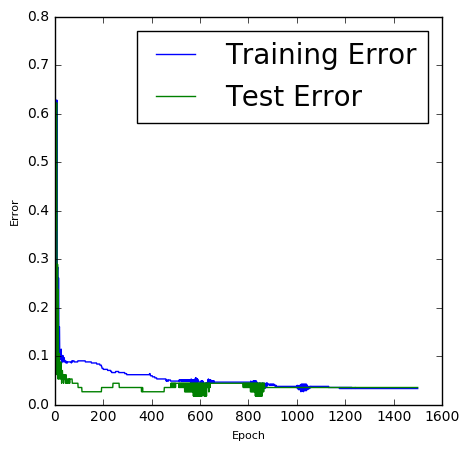

In [10]:
plt.figure(figsize=(5,5))
plt.plot(1-np.array(train_accs), label='Training Error')
plt.plot(1-np.array(test_accs), label='Test Error')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=8)
plt.ylabel('Error', fontsize=8)
plt.show()